# Helpers

In [1]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
import argparse
from IPython.display import clear_output

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')
from tqdm import tqdm

In [3]:
carbon_inds = [3,6,9,13]
mask = torch.zeros(14, dtype=torch.bool)
for i in carbon_inds: 
    mask[i] = True

def compute_gram_matrix_recentered_torch(x):
    n_atoms = int(x.shape[0]/3)
    coords = x.reshape((n_atoms,3))
    coords = coords[[3,6,9,13],:]
    rescaled_coords = coords - torch.mean(coords,dim=0).reshape(1,3)
    gram = torch.matmul(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

def compute_gram_matrix_recentered(x):
    assert x.shape[0]==12
    n_atoms = int(x.shape[0]/3)
    coords = x.reshape((n_atoms,3))
    rescaled_coords = coords - np.mean(coords,axis=0).reshape(1,3)
    gram = np.dot(rescaled_coords, rescaled_coords.T)
    return gram.flatten()

def recenter_bond_torch(x):
    x = x.reshape((4,3))
    recentered_x = x - x[1,:]
    theta = torch.sum(torch.atan2(recentered_x[...,1], recentered_x[...,0])*torch.Tensor([0,0,1,0]))
    M_xyT = torch.Tensor([[torch.cos(-theta), torch.sin(-theta), 0],[-torch.sin(-theta), torch.cos(-theta), 0], [0, 0, 1]])
    xy_rotated = torch.matmul(recentered_x, M_xyT)
    phi = torch.sum(torch.atan2(xy_rotated[...,2], xy_rotated[...,0])*torch.tensor([0,0,1,0]))
    M_zxT = torch.Tensor([[torch.cos(-phi),0, torch.sin(-phi)],[0, 1, 0], [-torch.sin(-phi), 0, torch.cos(-phi)]])
    zx_rotated = torch.matmul(xy_rotated, M_zxT)
    return zx_rotated.flatten()

def recenter_bond(x):
    x = x.reshape((4,3))
    assert x.shape == (4,3)
    recentered_x = x - x[1,:]
    theta = np.arctan2(recentered_x[2,1], recentered_x[2,0])
    xy_rotated = np.array([[np.cos(-theta), -np.sin(-theta), 0],[np.sin(-theta), np.cos(-theta), 0], [0, 0, 1]])@recentered_x.T
    xy_rotated = xy_rotated.T
    phi = np.arctan2(xy_rotated[2,2], xy_rotated[2,0])
    zx_rotated = np.array([[np.cos(-phi),0, -np.sin(-phi)],[0, 1, 0], [np.sin(-phi), 0, np.cos(-phi)]])@xy_rotated.T
    zx_rotated = zx_rotated.T
    return zx_rotated.flatten()

def recenter_bond_torch_with_mask(x):
    x = x.reshape((14,3))
    x = x[[3,6,9,13,],:]
    recentered_x = x - x[1,:]
    theta = torch.atan2(recentered_x[2,1], recentered_x[2,0])
    xy_rotated = torch.matmul(torch.Tensor([[torch.cos(-theta), -torch.sin(-theta), 0],[torch.sin(-theta), torch.cos(-theta), 0], [0, 0, 1]]),\
                              torch.transpose(recentered_x, 1, 0))
    xy_rotated = torch.transpose(xy_rotated,1,0)
    phi = torch.arctan2(xy_rotated[2,2], xy_rotated[2,0])
    zx_rotated = torch.matmul(torch.Tensor([[torch.cos(-phi),0, -torch.sin(-phi)],[0, 1, 0], [torch.sin(-phi), 0, torch.cos(-phi)]]), \
                              torch.transpose(xy_rotated,1,0))
    zx_rotated = torch.transpose(zx_rotated,1,0)
    return zx_rotated.flatten()

In [4]:
class RecenterBondLayer(nn.Module):
    def __init__(self, batch_mode=True):
        super(RecenterBondLayer, self).__init__()
        self.batch_mode = batch_mode

    def recenter_bond_torch(self, x):
        x = x.reshape((4, 3))
        assert x.shape == (4, 3)
        
        recentered_x = x - x[1, :]
        theta = torch.atan2(recentered_x[2, 1], recentered_x[2, 0])
        
        xy_rotated = torch.tensor([
            [torch.cos(-theta), -torch.sin(-theta), 0],
            [torch.sin(-theta), torch.cos(-theta), 0],
            [0, 0, 1]
        ]) @ recentered_x.T
        
        xy_rotated = xy_rotated.T
        phi = torch.atan2(xy_rotated[2, 2], xy_rotated[2, 0])
        
        zx_rotated = torch.tensor([
            [torch.cos(-phi), 0, -torch.sin(-phi)],
            [0, 1, 0],
            [torch.sin(-phi), 0, torch.cos(-phi)]
        ]) @ xy_rotated.T
        
        zx_rotated = zx_rotated.T
        
        return zx_rotated.flatten()

    def recenter_bond_batch_torch(self, batch_x):
        batch_size = batch_x.shape[0]
        batch_x = batch_x.reshape((batch_size, 4, 3)) # comment this out if you don't need it
        recentered_x = batch_x - batch_x[:, 1, :].unsqueeze(1)
        theta = torch.atan2(recentered_x[:, 2, 1], recentered_x[:, 2, 0])

        cos_theta = torch.cos(-theta)
        sin_theta = torch.sin(-theta)
        xy_rotation_matrix = torch.stack([
            torch.stack([cos_theta, -sin_theta, torch.zeros_like(cos_theta)], dim=-1),
            torch.stack([sin_theta, cos_theta, torch.zeros_like(cos_theta)], dim=-1),
            torch.stack([torch.zeros_like(cos_theta), torch.zeros_like(cos_theta), torch.ones_like(cos_theta)], dim=-1)
        ], dim=1)

        xy_rotated = torch.matmul(xy_rotation_matrix, recentered_x.transpose(1, 2)).transpose(1, 2)

        phi = torch.atan2(xy_rotated[:, 2, 2], xy_rotated[:, 2, 0])
        cos_phi = torch.cos(-phi)
        sin_phi = torch.sin(-phi)
        zx_rotation_matrix = torch.stack([
            torch.stack([cos_phi, torch.zeros_like(cos_phi), -sin_phi], dim=-1),
            torch.stack([torch.zeros_like(cos_phi), torch.ones_like(cos_phi), torch.zeros_like(cos_phi)], dim=-1),
            torch.stack([sin_phi, torch.zeros_like(cos_phi), cos_phi], dim=-1)
        ], dim=1)

        zx_rotated = torch.matmul(zx_rotation_matrix, xy_rotated.transpose(1, 2)).transpose(1, 2)
        return zx_rotated.reshape(batch_size, -1)

    def forward(self, x):
        if self.batch_mode:
            # If batch mode, x should have shape [batch_size, 4, 3]
            # assert x.dim() == 3 and x.shape[1:] == (4, 3), "Input must have shape [batch_size, 4, 3]"
            assert x.dim() == 2 and x.shape[1] == 12, "Input must have shape [batch_size, 4, 3]"
            return self.recenter_bond_batch_torch(x)
        else:
            # If not batch mode, x should have shape [4, 3]
            # assert x.dim() == 2 and x.shape == (4, 3), "Input must have shape [4, 3]"
            assert x.dim() == 1 and x.shape[0] == 12, "Input must have shape [batch_size, 4, 3]"
            return self.recenter_bond_torch(x)

In [5]:
import torch
import torch.nn as nn
class OrthogonalChangeOfBasisUnbatched(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input_data):
        # Ensure that the input data is 1D
        assert input_data.dim() == 1, "The input should be a 1-D tensor."
        # Reshape the input into points of shape (N//3, 3)
        points = input_data.view(-1, 3)
        points = points - points[6]
        p1, p2, p3 = points[9], points[6], points[13]
        v1 = p2 - p1
        v2 = p3 - p1
        normal_vector = torch.cross(v1, v2)
        normal_vector = normal_vector / torch.norm(normal_vector)
        v1 = v1 / torch.norm(v1)
        v2 = v2 - torch.dot(v2, v1) * v1  # Make v2 orthogonal to v1
        v2 = v2 / torch.norm(v2)
        R = torch.stack([v1, v2, normal_vector])
        transformed_points = torch.matmul(points, R.t())
        return transformed_points.flatten()
    
class OrthogonalChangeOfBasisBatchedFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_data):
        # Ensure that the input data is of shape (b, N)
        assert input_data.dim() == 2, "The input should be a 2-D tensor of shape (b, N)."
        # Reshape the input into points of shape (b, N//3, 3)
        b, N = input_data.shape
        points = input_data.view(b, -1, 3)
        points = points - points[:, 6, :].unsqueeze(1)
        # Extract the three points from indices 9, 6, and 13 for each batch element
        p1, p2, p3 = points[:, 9, :], points[:, 6, :], points[:, 13, :]
        # Calculate two vectors lying in the plane for each batch element
        v1 = p2 - p1
        v2 = p3 - p1
        # Calculate the normal vector to the plane using the cross product for each batch element
        normal_vector = torch.cross(v1, v2, dim=1)
        normal_vector = normal_vector / torch.norm(normal_vector, dim=1, keepdim=True)  # Normalize the normal vector
        # Normalize the vectors lying in the plane to form a basis for each batch element
        v1 = v1 / torch.norm(v1, dim=1, keepdim=True)
        v2 = v2 - torch.sum(v2 * v1, dim=1, keepdim=True) * v1  # Make v2 orthogonal to v1
        v2 = v2 / torch.norm(v2, dim=1, keepdim=True)
        # Form an orthonormal basis from v1, v2, and the normal vector for each batch element
        R = torch.stack([v1, v2, normal_vector], dim=1)  # Shape: (b, 3, 3)
        # Transform each row of the points by multiplying with the transpose of R for each batch element
        transformed_points = torch.bmm(points, R.transpose(1, 2))
        # Save R for potential debugging or backward calculations if needed
        ctx.save_for_backward(R)
        # Flatten each batch element and return as a 2-D tensor of shape (b, N)
        return transformed_points.view(b, -1)

class OrthogonalChangeOfBasisBatched(nn.Module):
    def forward(self, input_data):
        return OrthogonalChangeOfBasisBatchedFunction.apply(input_data)


# Data

In [ ]:
fname = "ground_data/butane_nonaligned.npz" #butane_metad.npz DNMTBut.npz butane_hightemp.npz
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

data_meta = inData["data"]
dataMetaD = data_meta
print("Data shape from trajectory:")
print(dataMetaD.shape)
dihedralsMetaD = inData["dihedrals"] # the one dim dihedral angles
potentialMetaD = inData["potential"] # potential related to the particular data point
print(potentialMetaD.shape)
print(dihedralsMetaD.shape)
kbT_roomtemp = inData["kbT_roomtemp"]

Keys in data:
['data', 'data_all_atom', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp', 'free_energy', 'biasFactor', 'biasWidth', 'height', 'frequency']
Data shape from trajectory:
(100000, 12)
(100000,)
(100000,)


## Visualize Dihedrals

In [7]:
data = dataMetaD[::10, :]
dihedrals = dihedralsMetaD[::10]
potentials = potentialMetaD[::10]
target_measure = np.exp(-potentials/(kbT_roomtemp))

Text(0, 0.5, 'number of data points')

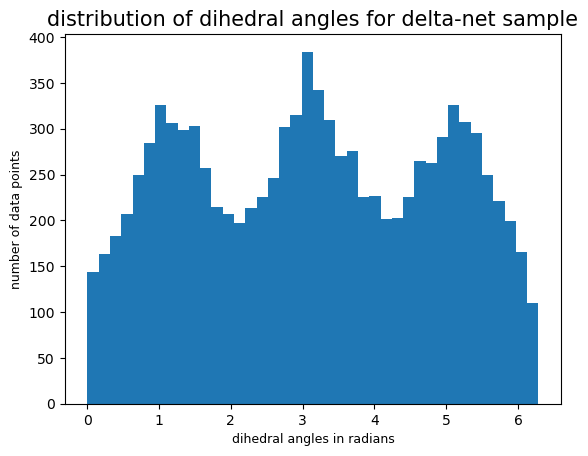

In [8]:
plt.hist(dihedrals, 40) 
plt.title("distribution of dihedral angles for delta-net sample", fontsize = 15)
plt.xlabel("dihedral angles in radians", fontsize = 9)
plt.ylabel("number of data points", fontsize = 9)
# plt.savefig("dihedral_dist_metad.pdf")

## Load tmdmap

In [24]:
diff_data = np.load("tmdmap_carbons_recentered12_alphazero_sep29_2024.npz", allow_pickle=True)
# the relevant indices are 1, 2, 3. 

# comment out the following for jul 25 data. 
dim = 4
diffcoords = diff_data['diffcoords'][:,:dim]
L = diff_data['L']
eigvals = diff_data['eigvals']
Ltorch = torch.Tensor(L)
eigvals_mat = torch.Tensor(eigvals)[:dim,:dim]

# diffcoords = np.load("tmdmap_carbons_recentered12_alphazero_jul25_2024.npz")
# diffcoords = diffcoords['arr_0']
# diffcoords = diff_data['arr_0']

In [25]:
size_vec = np.pi - np.abs(dihedrals - np.pi)
dihedrals_vec = np.abs(dihedrals - np.pi)

In [26]:
diffcoords.shape

(10000, 4)

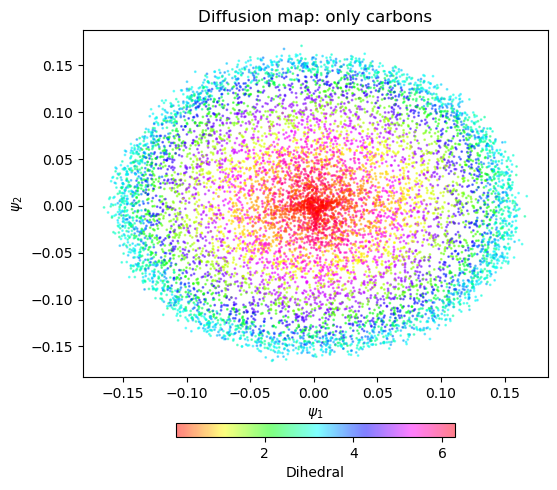

In [27]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(diffcoords[:, 0], diffcoords[:, 1], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

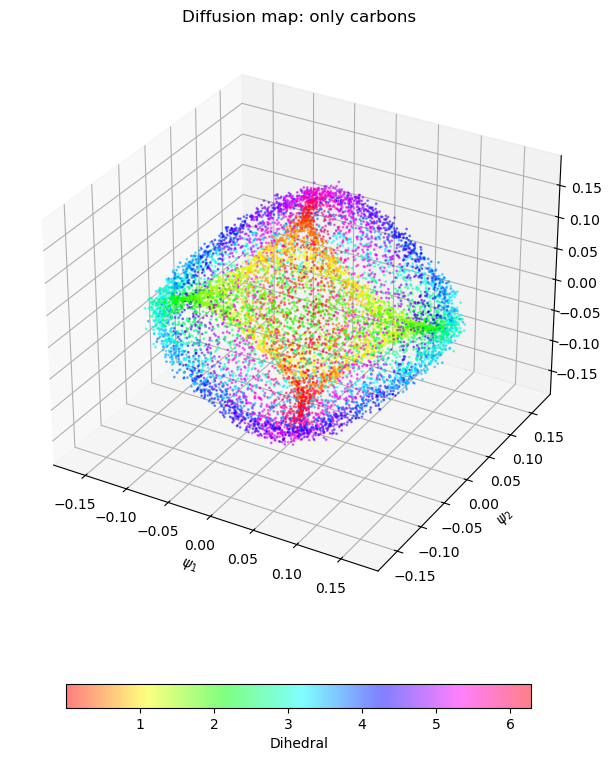

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(diffcoords[:, 0], diffcoords[:, 1], diffcoords[:,2], \
               c=dihedrals, cmap='hsv', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

# Learn Diffusion Net

## NN architectures

In [29]:
# setup featurizer
# feature_map = torch.vmap(compute_gram_matrix_recentered_torch)
layer = RecenterBondLayer(batch_mode=True)  # Enable batch mode


In [35]:
layer = OrthogonalChangeOfBasisBatched()


In [30]:
np.random.seed(10)
torch.manual_seed(10)
# For defining operations on cuda if computer has it available
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:2 device


In [31]:
class periodic_activation(nn.Module):
    def __init__(self):
        super(periodic_activation, self).__init__()
    def forward(self,x): 
        return x + torch.sin(x)**2
        
class Encoder(nn.Module):
    def __init__(self, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim):
        super(Encoder, self).__init__()
        
        # Defining the layers of the neural network
        # self.featurizer = feature_map
        self.activation = activation
        self.hidden1 = nn.Linear(input_dim, hidden1_dim)
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.hidden3 = nn.Linear(hidden2_dim, hidden3_dim)
        self.hidden4 = nn.Linear(hidden3_dim, hidden4_dim)
        self.bottleneck = nn.Linear(hidden4_dim, encoder_dim)

        # Collecting layers for convenience
        self.encoder = nn.Sequential(self.hidden1, self.activation, \
                                     self.hidden2, self.activation, \
                                        self.hidden3, self.activation, \
                                            self.hidden4, self.activation, \
                                                self.bottleneck, self.activation)

    
    def encode(self, x):
        # y = self.featurizer(x)
        return self.encoder(x)
    
    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        # x = self.featurizer(x)
        return self.encode(x)

In [32]:
class Decoder(nn.Module):
    def __init__(self, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim):
        super(Decoder, self).__init__()
        
        # Defining the layers of the neural network
        self.activation = activation
        self.hidden4 = nn.Linear(encoder_dim, hidden4_dim)
        self.hidden3 = nn.Linear(hidden4_dim, hidden3_dim)
        self.hidden2 = nn.Linear(hidden3_dim, hidden2_dim)
        self.hidden1 = nn.Linear(hidden2_dim, hidden1_dim)
        self.reconstruct = nn.Linear(hidden1_dim, input_dim)

        # Collecting layers for convenience as encoder and decoder
        self.decoder = nn.Sequential(self.hidden4, self.activation, self.hidden3, self.activation, self.hidden2, self.activation, self.hidden1, self.activation, self.reconstruct)

    
    def decode(self, z):
        return self.decoder(z)
        
    # Required for any subclass of nn.module: defines how data passes through the `computational graph'
    def forward(self, x):
        return self.decode(x)

In [46]:
# this defines the structure of the model

activation = nn.Tanh() 
# activation = periodic_activation()
input_dim = 12
hidden1_dim = 32
hidden2_dim = 32
hidden3_dim = 32
hidden4_dim = 32
encoder_dim = 4
output_dim = 42


# regular models:

# initializing the optimizer for the decoder
model_decoder_reg = Decoder(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_reg_dec = optim.Adam(model_decoder_reg.parameters(), lr=1e-4, weight_decay = 1e-5)

# initializing the optimizer for the encoder
model_encoder_reg = Encoder(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_reg_enc = optim.Adam(model_encoder_reg.parameters(), lr = 1e-4, weight_decay=1e-5)

# the parameter values have been tuned to obtain convergence and an image resembling that of the tmdmap

loss_function = nn.MSELoss()

In [47]:
# set up output data
out = diffcoords[:,:dim]
print(out.shape)
outtorch = torch.from_numpy(out).float().T # converted our output from diff map to torch
print(outtorch.shape)

# set up input data
train_data = torch.from_numpy(data).float() # converting the data to torch tensor
num_points = train_data.shape[0] 
# train_data = train_data_flat.reshape((num_points, 4, 3))
gram_matrices_train = layer(train_data).T
# train_data = data[:, :] 
# we could divide the data into two sets for training and testing.
# but, for the final implementation i decided to use all the tmdmap data for training (to improve accuracy), since it was established through testing that the network converged well.
print(train_data.shape)

(10000, 4)
torch.Size([4, 10000])
torch.Size([10000, 12])


In [48]:
train_data.shape

torch.Size([10000, 12])

In [49]:
np.random.seed(10)
torch.manual_seed(10)
# For defining operations on cuda if computer has it available
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
# dim = 4 # dimension of the output layer of the NN
train = True
# eigvals_mat = torch.diag(torch.Tensor(eigvals[:dim]))

Using cuda:2 device


In [50]:
class MyDataset(torch.utils.data.Dataset):
    """Basic dataset container

    Parameters
    ----------
     data_tensor : (num_features, num_data) Tensor
         
    """    
    def __init__(self, data_tensor, diffmap_tensor, gram_matrices_tensor): # CHANGED 
        self.data_tensor = data_tensor
        self.diffmap_tensor = diffmap_tensor
        self.gram_matrices = gram_matrices_tensor
    def __getitem__(self, index):
        return index, self.data_tensor[index], self.diffmap_tensor[index], self.gram_matrices[index]
    def __len__(self):
        return self.data_tensor.size(0)

class LaggedDataset(torch.utils.data.Dataset): # An iterator that returns a tuple with (originalData, TimeLaggedOriginalData, TMDiffusionMapData) on each iteration
    """ Container for creating and utilizing time-lagged time-series

    Parameters
    ----------
        data_tensor : (num_features, num_data) Tensor
            time series dataset
        lag: integer
            number of frames for time-lag
    """    
    def __init__(self, data_tensor, diffmap_tensor, lag=1):
        assert data_tensor.size(0) > lag, 'you need more samples than lag'
        assert lag >= 0, 'you need a non-negative lagtime'
        self.data_tensor = data_tensor
        self.lag = lag
        self.diffmap_tensor = diffmap_tensor
    def __getitem__(self, index):
        return index, self.data_tensor[index], self.data_tensor[index + self.lag], self.diffmap_tensor[index]
    def __len__(self):
        return self.data_tensor.size(0) - self.lag

In [51]:
regular_data = MyDataset(train_data, outtorch.T[:, :dim], gram_matrices_train.T)
train_loader = torch.utils.data.DataLoader(regular_data, batch_size=128, shuffle=True)

In [53]:
_, (idx, data, diffusion_map, features) = next(enumerate(train_loader))

In [58]:
def jj_transpose_loss(model,inputs):
    j_phi = torch.autograd.functional.jacobian(model, inputs)
    jj_prod = torch.einsum('ijkl,imkl -> ijkm', j_phi, j_phi)
    jj_prod_pruned = torch.diagonal(jj_prod, dim1=0, dim2=2)
    jj_minus_i = jj_prod_pruned-torch.eye(2).unsqueeze(2).repeat(1,1,inputs.shape[0])
    return loss_function(jj_minus_i, torch.zeros(jj_minus_i.shape))

In [59]:
mse_loss = torch.nn.MSELoss()

In [77]:
def train_sep(model_enc, model_dec, optimizer_enc, optimizer_dec, epoch, train_loader,verbose=False): # training for regular autoencoder
    model_enc.train()
    model_dec.train()
    loss1 = 0 # loss associated with the encoder
    loss2 = 0 
    loss3 = 0 
    loss4 = 0 # loss associated with the decoder
    
    # training loop
    for batch_idx, (indices, _, diff_map, features) in enumerate(train_loader):
        # data = data.to(device)
        diff_map = diff_map.to(device)
        features = features.to(device)
        features.requires_grad_(True)
        encoded_data = model_enc(features.float()) 
        decoded_data = model_dec(encoded_data)

        optimizer_enc.zero_grad() 
        optimizer_dec.zero_grad()
        
        # loss_tmd = loss_function(encoded_data, diff_map.float())
        jacobians = []
        for i in range(2):
            jj = torch.autograd.grad(encoded_data[:,i].sum(), features, create_graph=True)[0]
            jacobians.append(jj)
        inner_prods = torch.sum(jacobians[0]*jacobians[1], dim=1)
        loss_tmd = mse_loss(inner_prods, torch.zeros_like(inner_prods))

        loss_dec = loss_function(decoded_data, features.float())
        loss_eigs = torch.mean((torch.matmul(Ltorch[:,indices].to(device), encoded_data)[indices,...]-\
                     torch.matmul(encoded_data, eigvals_mat.to(device)))**2)

        loss_enc = 10.0*loss_tmd + 0.5*loss_eigs

        loss_total = loss_enc + loss_dec
        # loss_enc.backward(retain_graph=True)
        # loss_dec.backward()
        loss_total.backward(retain_graph = True)
        optimizer_enc.step()
        optimizer_dec.step()
        loss1 += loss_tmd.item()
        loss2 += loss_eigs.item()
        loss3 += loss_enc.item()
        loss4 += loss_dec.item()
    if verbose:
        print(f'====> Average loss: {loss1:.4f}, {loss2:.4f}, {loss3:.4f}')
        print('====> Average decoder loss: {:.4f}'.format(
             loss4 / len(train_loader.dataset)))
    # clear_output(wait=True)


In [78]:
lag = 10 # defining the lag for the time-lagged autoencoder
batch_size = 64 
num_epochs = 500
train = True
if train:
    for epoch in tqdm(range(num_epochs)):
        # print(f"epoch {epoch}:")
        if epoch % 50 == 0:
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, epoch, train_loader, True)
        else: 
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, epoch, train_loader, False)

  0%|▏                                                                                                     | 1/500 [00:01<09:02,  1.09s/it]

====> Average loss: 0.0003, 0.0001, 0.0026
====> Average decoder loss: 0.0000


 10%|██████████▎                                                                                          | 51/500 [00:56<08:34,  1.15s/it]

====> Average loss: 0.0001, 0.0001, 0.0011
====> Average decoder loss: 0.0000


 20%|████████████████████▏                                                                               | 101/500 [01:54<08:13,  1.24s/it]

====> Average loss: 0.0001, 0.0001, 0.0009
====> Average decoder loss: 0.0000


 30%|██████████████████████████████▏                                                                     | 151/500 [02:54<07:21,  1.26s/it]

====> Average loss: 0.0001, 0.0001, 0.0007
====> Average decoder loss: 0.0000


 40%|████████████████████████████████████████▏                                                           | 201/500 [03:55<05:49,  1.17s/it]

====> Average loss: 0.0001, 0.0001, 0.0006
====> Average decoder loss: 0.0000


 50%|██████████████████████████████████████████████████▏                                                 | 251/500 [04:54<04:44,  1.14s/it]

====> Average loss: 0.0000, 0.0001, 0.0004
====> Average decoder loss: 0.0000


 60%|████████████████████████████████████████████████████████████▏                                       | 301/500 [05:46<03:16,  1.01it/s]

====> Average loss: 0.0000, 0.0001, 0.0004
====> Average decoder loss: 0.0000


 70%|██████████████████████████████████████████████████████████████████████▏                             | 351/500 [06:47<03:14,  1.30s/it]

====> Average loss: 0.0000, 0.0001, 0.0003
====> Average decoder loss: 0.0000


 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 401/500 [07:46<01:40,  1.01s/it]

====> Average loss: 0.0000, 0.0001, 0.0003
====> Average decoder loss: 0.0000


 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 451/500 [08:32<01:02,  1.29s/it]

====> Average loss: 0.0000, 0.0001, 0.0003
====> Average decoder loss: 0.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:34<00:00,  1.15s/it]


# Test the diffusion net 

In [79]:
loader = False
if loader: 
    model_encoder_reg = Encoder(periodic_activation(), input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, 4).to(device)
    model_encoder_reg.load_state_dict(torch.load("model_encoder_DNet_Laplacian_28oct2024", map_location=device))
model_encoder_reg.eval()

Encoder(
  (activation): Tanh()
  (hidden1): Linear(in_features=12, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=32, bias=True)
  (bottleneck): Linear(in_features=32, out_features=4, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=4, bias=True)
    (9): Tanh()
  )
)

In [63]:
# construct testing set 
num_points_test = dataMetaD.shape[0]
test_data = torch.Tensor(dataMetaD.reshape((num_points_test, 4, 3)))
# test_data = torch.Tensor(dataMetaD.reshape((num_points_test, 42)))
gram_matrices_test = layer(test_data)
# gram_matrices_test = test_data

AssertionError: Input must have shape [batch_size, 4, 3]

In [64]:
test_data.shape

torch.Size([100000, 4, 3])

In [80]:
encoded_out_nontl = model_encoder_reg(gram_matrices_train.T.float().to(device)).detach().cpu().numpy()
# encoded_out_test_nontl = model_encoder_reg(torch.from_numpy(gram_matrices_test).to(device).float()).detach() #test_data
# encoded_out_test_nontl = model_encoder_reg(gram_matrices_test.to(device).float()).detach() #test_data
# reconst_out_nontl = model_decoder_reg(encoded_out_nontl).T.detach()

In [195]:
gram_matrices_test = gram_matrices_test.to(device).float()
gram_matrices_test.requires_grad_(True)
encoded_out_test_nontl = model_encoder_reg(gram_matrices_test)
y = torch.arctan2(encoded_out_test_nontl[...,1], encoded_out_test_nontl[...,0])

In [196]:
grads = torch.autograd.grad(y.sum(), gram_matrices_test)[0]
grads = grads.cpu().numpy()

In [158]:
encoded_out_test_nontl = encoded_out_test_nontl.detach().cpu().numpy()
encoded_out_nontl = encoded_out_nontl.cpu().numpy()
# encoded_out_test_nontl = model_encoder_reg(torch.from_numpy(gram_matrices_test).to(device).float()).detach() #test_data
# reconst_out_nontl = model_decoder_reg(encoded_out_nontl).T.detach()

In [159]:
size_vec = np.pi - np.abs(dihedralsMetaD-np.pi)
dihedrals_vec = np.abs(dihedralsMetaD - np.pi)
test_indices = ~np.zeros(encoded_out_test_nontl.shape[0],dtype=bool)
test_indices[::10] = False

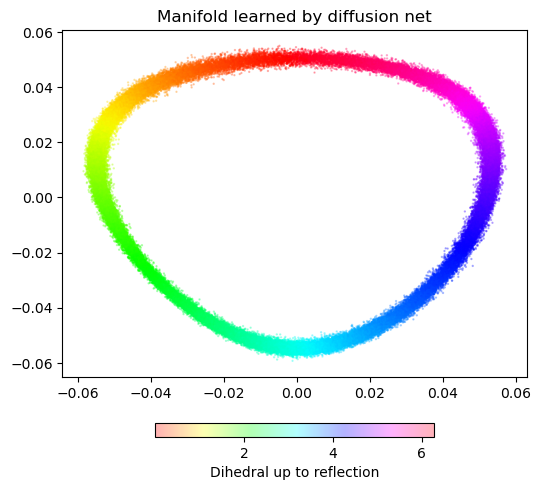

In [160]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(encoded_out_test_nontl[test_indices, 0], \
               encoded_out_test_nontl[test_indices, 1], \
               c=dihedralsMetaD[test_indices], cmap='hsv', s=0.5, alpha=0.3)
ax.set_title("Manifold learned by diffusion net")
# ax.view_init(elev=50, azim=120, roll=0)
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral up to reflection')

In [81]:
encoded_out_nontl

array([[-0.341647  , -0.4680397 , -0.39995316, -0.23952405],
       [ 0.04170794,  0.49508202, -0.56504774, -0.12134247],
       [ 0.4845602 , -0.13553657, -0.17459753,  0.559803  ],
       ...,
       [-0.44758418, -0.1569176 ,  0.33378583,  0.55818367],
       [ 0.51349694,  0.21097822, -0.1919363 ,  0.56372833],
       [-0.40537503, -0.29131922, -0.21193373, -0.40703788]],
      dtype=float32)

(10000, 4)


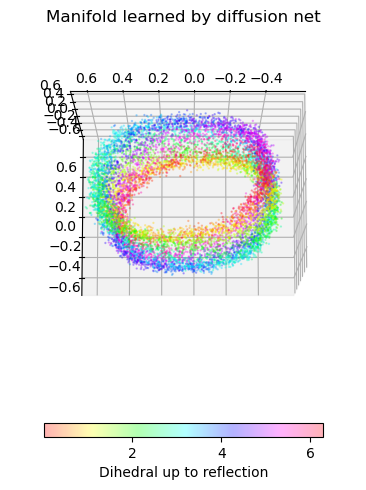

In [92]:
print(encoded_out_nontl.shape)
# reconst_out_nontl = reconst_out_nontl.numpy()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(encoded_out_nontl[:, 0], \
               encoded_out_nontl[:, 1], \
               encoded_out_nontl[:, 2], \
               c=dihedrals, cmap='hsv', s=0.5, alpha=0.3)
ax.set_title("Manifold learned by diffusion net")
ax.view_init(elev=-10, azim=90, roll=0)
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral up to reflection')

In [115]:
pointcloud = encoded_out_test_nontl[test_indices, :]
angles = dihedralsMetaD[test_indices]

In [116]:
np.savetxt("pointcloud_oct9.csv", pointcloud, delimiter=',')
np.savetxt("dihedrals_oct9.csv", angles, delimiter=',')

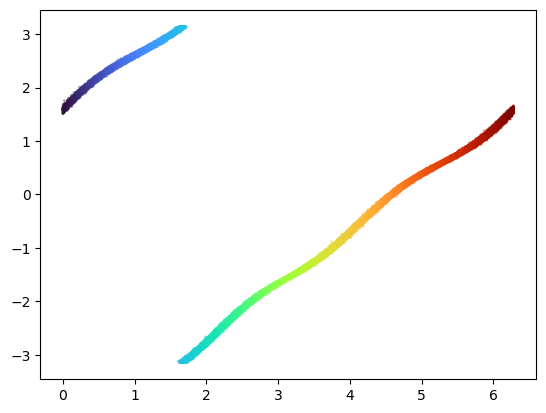

In [144]:
plt.scatter(dihedralsMetaD[test_indices],\
            np.arctan2(encoded_out_test_nontl[test_indices,1],encoded_out_test_nontl[test_indices,0]),\
            c=dihedralsMetaD[test_indices],s=1.0, cmap='turbo', alpha=0.3)

In [161]:
diff_tensors = np.linalg.norm(grads, axis=1)**2

In [162]:
diff_tensors.shape

(100000,)

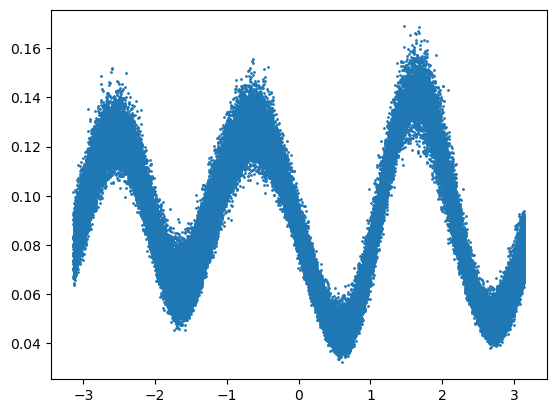

In [163]:
plt.scatter(np.arctan2(encoded_out_test_nontl[test_indices,1],encoded_out_test_nontl[test_indices,0]), \
            diff_tensors[test_indices], s=1.0)

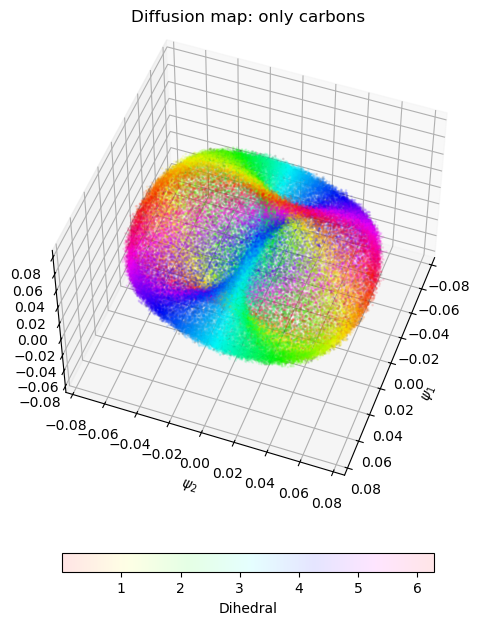

In [44]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(encoded_out_test_nontl[test_indices,0], encoded_out_test_nontl[test_indices, 1], encoded_out_test_nontl[test_indices,2], \
               c=dihedralsMetaD[test_indices], cmap='hsv', s=1.0, alpha=0.1)
p1 = ax.scatter(encoded_out_test_nontl[~test_indices,0], encoded_out_test_nontl[~test_indices, 1], encoded_out_test_nontl[~test_indices,2], \
               c='k', s=1.0, alpha=0.1)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
ax.view_init(azim=azim+80, elev=50, roll=roll)
plt.show()

In [149]:
# save neural network model

saver = True
if saver:
    torch.save(model_encoder_reg.state_dict(), "model_encoder_DNet_Laplacian_24nov2024")

# Fiddle with CV

In [40]:
class collective_variable(nn.Module):
    def __init__(self, featurizer, Dnet): 
        super().__init__()
        self.featurizer = featurizer
        self.Dnet = Dnet
    def forward(self,x):
        x = self.featurizer(x) 
        x = self.Dnet(x).flatten()
        return x[-1]

In [41]:
featurizer = RecenterBondLayer(batch_mode=False)
collective_var = collective_variable(featurizer, model_encoder_reg)

In [42]:
J = []
for i in tqdm(range(num_points_test)):
    j = torch.autograd.functional.jacobian(collective_var, test_data[i,:,:])
    J.append(torch.norm(j)**2)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:05<00:00, 1516.97it/s]


In [43]:
J = torch.Tensor(J).numpy()

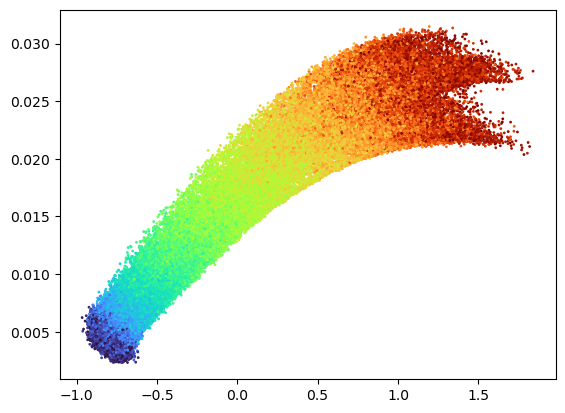

In [44]:
plt.scatter(10*r, J, c=dihedrals_vec, s=1.0, cmap='turbo')